In [1]:
import os
import json
import numpy as np
from scipy.stats import kendalltau
from scipy.spatial import ConvexHull
from scipy.spatial.qhull import QhullError
from scipy.spatial.distance import cdist, pdist
from operator import itemgetter
from itertools import chain
from pyemd import emd_samples
from src.lexrank import degree_centrality_scores

from sklearn.decomposition import PCA

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

import ray

from config import *
from helpers import *
from visualization import *

In [2]:
DATASET = DATASETS[0]
IN_DATA_DIR = f'/scratch/korunosk/data'
OUT_DATA_DIR = f'/scratch/korunosk/data/GloVe/{DATASET}'

In [3]:
ray.init(num_cpus=40)

2020-03-10 00:29:57,892	WARNING services.py:586 -- setpgrp failed, processes may not be cleaned up properly: [Errno 1] Operation not permitted.
2020-03-10 00:29:57,899	INFO resource_spec.py:212 -- Starting Ray with 32.91 GiB memory available for workers and up to 16.48 GiB for objects. You can adjust these settings with ray.init(memory=<bytes>, object_store_memory=<bytes>).
2020-03-10 00:29:58,303	INFO services.py:1078 -- View the Ray dashboard at localhost:8268


{'node_ip_address': '10.90.36.41',
 'redis_address': '10.90.36.41:46407',
 'object_store_address': '/tmp/ray/session_2020-03-10_00-29-57_891410_91971/sockets/plasma_store',
 'raylet_socket_name': '/tmp/ray/session_2020-03-10_00-29-57_891410_91971/sockets/raylet',
 'webui_url': 'localhost:8268',
 'session_dir': '/tmp/ray/session_2020-03-10_00-29-57_891410_91971'}

In [4]:
@ray.remote
def load_and_extract(topic_id):
    topic = load_data(OUT_DATA_DIR, topic_id, encoded=True)
    return extract(topic)

In [5]:
def execute_experiment(tac, experiment):
    data   = [ load_and_extract.remote(topic_id) for topic_id in tac ]
    scores = [ experiment.remote(d) for d in data ]

    return np.array(ray.get(scores))

In [6]:
@ray.remote
def experiment_average_pairwise_distance(data):
    document_embs, summary_embs, indices, pyr_scores, summary_ids = data
    
    def average_pairwise_distance(summary_embs: np.array) -> float:
        '''Calculates the average pairwise distance between summary embeddings'''
        return np.mean(cdist(summary_embs, summary_embs, metric='euclidean'))
    
    metric = lambda i: average_pairwise_distance(summary_embs[i[0]:i[1]])
    
    return kendalltau(pyr_scores, np.array([metric(i) for i in indices]))[0]

@ray.remote
def experiment_semantic_volume(data):
    document_embs, summary_embs, indices, pyr_scores, summary_ids = data
    
    embs = np.concatenate((document_embs, summary_embs))
    t = document_embs.shape[0]
    pca = PCA(n_components=2, random_state=42)
    pts = pca.fit_transform(embs)
    document_pts, summary_pts = pts[:t], pts[t:]
    
    def semantic_volume(summary_embs: np.array) -> float:
        '''Calculates the semantic volume of the summary embeddings'''
        try:
            return ConvexHull(summary_embs).volume
        except QhullError as e:
            return 0
    
    metric = lambda i: semantic_volume(summary_pts[i[0]:i[1]])
    
    return kendalltau(pyr_scores, np.array([metric(i) for i in indices]))[0]

@ray.remote
def experiment_semantic_spread(data):
    document_embs, summary_embs, indices, pyr_scores, summary_ids = data

    def semantic_spread(summary_embs: np.array) -> float:
        '''Calculates the semantic spread of the summary embeddings'''
        return np.linalg.det(summary_embs @ summary_embs.T)

    metric = lambda i: semantic_spread(summary_embs[i[0]:i[1]])
    
    return kendalltau(pyr_scores, np.array([metric(i) for i in indices]))[0]

@ray.remote
def experiment_earth_mover_distance(data):
    document_embs, summary_embs, indices, pyr_scores, summary_ids = data
    
    def earth_mover_distance(document_embs: np.array, summary_embs: np.array) -> float:
        '''Calculates the Earth Mover distance between the document and summary distributions.'''
        return emd_samples(document_embs, summary_embs)
    
    metric = lambda i: earth_mover_distance(document_embs, summary_embs[i[0]:i[1]])
    
    return kendalltau(pyr_scores, np.array([metric(i) for i in indices]))[0]

@ray.remote
def experiment_lex_rank(data):
    document_embs, summary_embs, indices, pyr_scores, summary_ids = data
    
    lr_scores = degree_centrality_scores(cdist(document_embs, document_embs, metric='cosine'))
    
    def lex_rank(document_embs: np.array, summary_embs: np.array, lr_scores: np.array) -> float:
        '''Calculates the LexRank score of the summary based on the documents LexRank score.'''
        return np.sum(lr_scores[np.argmax(cdist(summary_embs, document_embs, metric='cosine'), axis=1)])
    
    metric = lambda i: lex_rank(document_embs, summary_embs[i[0]:i[1]], lr_scores)
    
    return kendalltau(pyr_scores, np.array([metric(i) for i in indices]))[0]

In [7]:
scores = [
    {
        'label': 'Average pairwise distance',
        'experiment': experiment_average_pairwise_distance 
    },
    {
        'label': 'Semantic volume',
        'experiment': experiment_semantic_volume 
    },
    {
        'label': 'Semantic spread',
        'experiment': experiment_semantic_spread 
    },
    {
        'label': 'Earth Mover distance',
        'experiment': experiment_earth_mover_distance 
    },
#     {
#         'label': 'LexRank',
#         'experiment': experiment_lex_rank 
#     },
]

ptr = ''
print(f'=== Experiments {DATASET} ===\n')
for i,s in enumerate(scores):
    print('   Executing "{}"'.format(s['label']))
    scores[i]['values'] = execute_experiment(TOPICS[DATASET], s['experiment'])
    ptr += '   {:30} {:.4}\n'.format(s['label'], np.mean(scores[i]['values']))
    del s['experiment']
print('\n=== Results ===\n')
print(ptr)

=== Experiments TAC2008 ===

   Executing "Average pairwise distance"
   Executing "Semantic volume"
   Executing "Semantic spread"
   Executing "Earth Mover distance"

=== Results ===

   Average pairwise distance      0.04787
   Semantic volume                0.1244
   Semantic spread                -0.03973
   Earth Mover distance           -0.02333



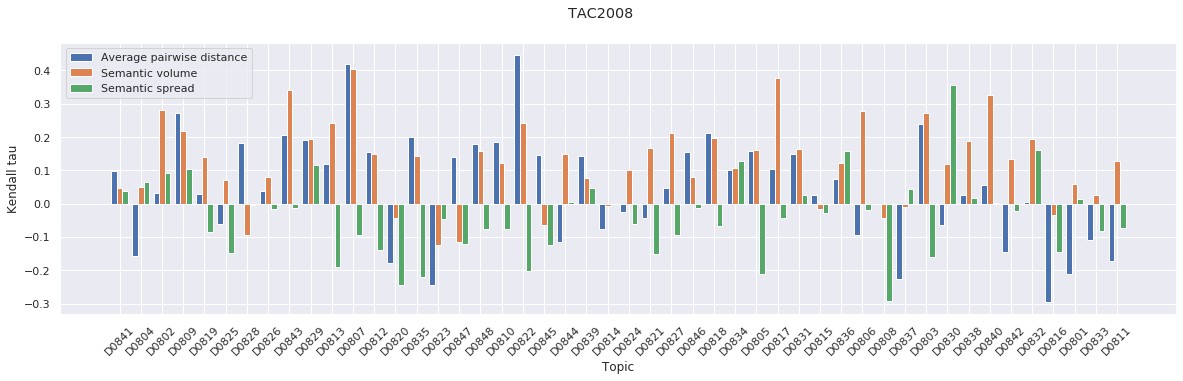

In [8]:
fig = plt.figure(figsize=(20,5))
fig.suptitle(DATASET)
ax = fig.add_subplot(1,1,1)
plot_corr(ax, TOPICS[DATASET], scores[:-1])
plt.show()

In [8]:
ray.shutdown()

## Export GloVe

In [13]:
from gensim.parsing.preprocessing import *
filters = [
    lambda s: s.lower(),
    strip_punctuation,
    strip_multiple_whitespaces,
    remove_stopwords,
]

In [14]:
with open('/scratch/korunosk/data/GloVe/glove.6B.50d.txt', mode='r') as fp:
    embs = {}
    for line in fp.readlines():
        tokens = line.strip().split()
        embs[tokens[0]] = list(map(float, tokens[1:]))

In [15]:
def encode_words(documents):
    def encode(sentence):
        words = preprocess_string(sentence, filters)
        return [ embs[w] for w in words if w in embs ]
    document_embs = []
    for document in documents:
        sentence_embs = []
        for sentence in document:
            sentence_embs.extend(encode(sentence))
        document_embs.append(sentence_embs)
    return document_embs

In [16]:
for dataset in DATASETS:
    print(dataset)
    data = load_data(IN_DATA_DIR, dataset, encoded=False)
    for topic_id, topic in data.items():
        print('  ', topic_id)
        store_data(OUT_DATA_DIR, topic_id, make_topic(topic, encode_words))

TAC2008
   D0841
   D0804
   D0802
   D0809
   D0819
   D0825
   D0828
   D0826
   D0843
   D0829
   D0813
   D0807
   D0812
   D0820
   D0835
   D0823
   D0847
   D0848
   D0810
   D0822
   D0845
   D0844
   D0839
   D0814
   D0824
   D0821
   D0827
   D0846
   D0818
   D0834
   D0805
   D0817
   D0831
   D0815
   D0836
   D0806
   D0808
   D0837
   D0803
   D0830
   D0838
   D0840
   D0842
   D0832
   D0816
   D0801
   D0833
   D0811
TAC2009
   D0919
   D0904
   D0934
   D0928
   D0944
   D0917
   D0926
   D0921
   D0930
   D0907
   D0929
   D0913
   D0920
   D0909
   D0922
   D0935
   D0912
   D0903
   D0927
   D0940
   D0902
   D0925
   D0910
   D0931
   D0943
   D0939
   D0937
   D0933
   D0915
   D0941
   D0911
   D0924
   D0908
   D0932
   D0914
   D0916
   D0905
   D0923
   D0936
   D0938
   D0942
   D0918
   D0901
   D0906
